In [1]:
import numpy as np
from tools import *
import seaborn as sns; sns.set_theme()
from matplotlib.pyplot import figure
sns.set(rc={'figure.figsize':(18,8)})
%load_ext autoreload
%autoreload 2



In [2]:
resPH, stimPH = read_lmc('PHOTO');

In [8]:
def eig_iter_v1(a, b, eta, n=100, w=None, l=None):

    if type(w) == type(None):
        w = np.random.randn(a.shape[0])
    else:
        w = np.copy(w)
    if type(l) == type(None):
        l = (w @ a @ w) / (w @ b @ w)

    l_hist, w_hist = [], []

    l_hist.append(l)
    w_hist.append(np.copy(w))

    for _ in range(n):

        w += eta * (a - l * b) @ w
        l = w @ a @ w / (w @ b @ w)

        l_hist.append(l)
        w_hist.append(np.copy(w))

    return w, l, w_hist, l_hist



def eig_iter_v2(a, b, eta, n=100, w=None, l=None):

    if type(w) == type(None):
        w = np.random.randn(a.shape[0])
    else:
        w = np.copy(w)
    if type(l) == type(None):
        l = (w @ a @ w) / (w @ b @ w)

    l_hist, w_hist = [], []

    l_hist.append(l)
    w_hist.append(np.copy(w))

    for _ in range(n):

        delta_w = eta * (a - l * b) @ w

        w += delta_w
        l = 0.01 * (w @ b @ w)

        l_hist.append(l)
        w_hist.append(np.copy(w))

    return w, l, w_hist, l_hist

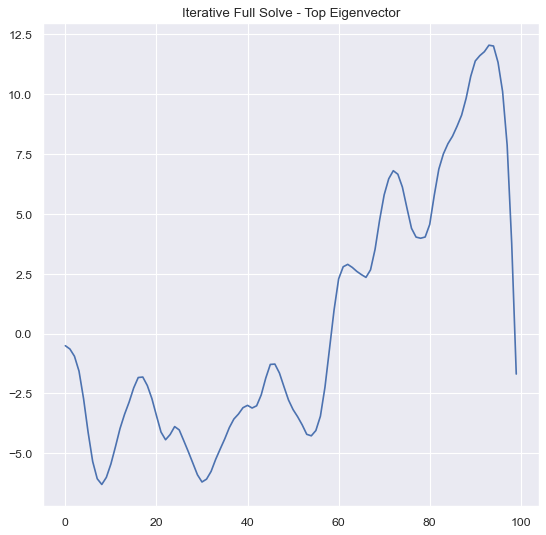

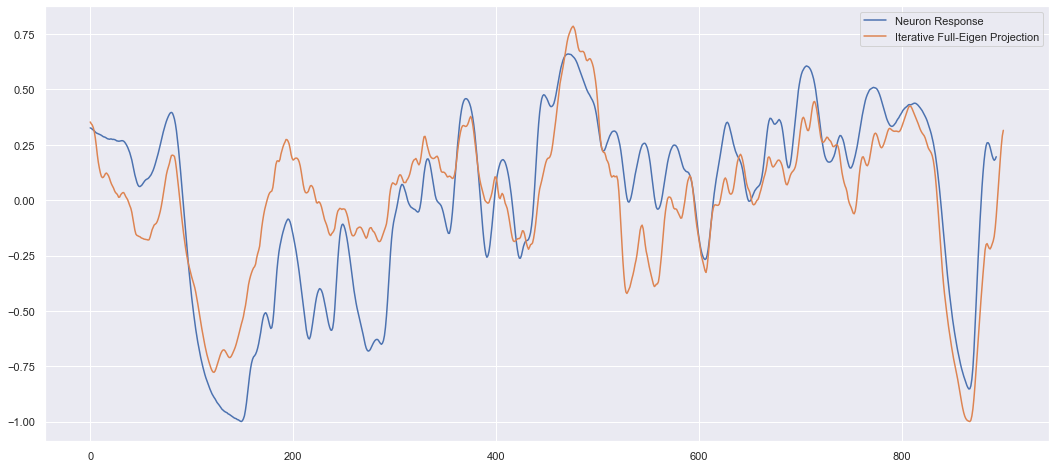

Correlation Shift: 106


In [55]:
# Iterative Full-Eigen Projection
down = 10
sig = normalize(np.mean(stimPH[:, ::down], axis=0))
res = normalize(np.mean(resPH[:, ::down], axis=0))

shift = 1
N = 100
# build Hankels for X, X_0 and X_+
X = build_hankel(sig, N)
X0 = X[:, :-shift]
Xp = X[:, shift:]

X0Xp = X0 @ Xp.T  # / X0.shape[1]
X0X0 = X0 @ X0.T  # / X0.shape[1]

largest_evec, l, w_hist, l_hist = eig_iter_v1(X0Xp, X0X0, n=10000, eta=0.0001)

# sgn
largest_evec *= -1
# project original series onto largest_evec
proj_series = largest_evec @ X


figure(figsize = (8, 8), dpi = 80)
plt.plot(largest_evec); plt.title("Iterative Full Solve - Top Eigenvector"); plt.show();

lags, corr = cross_corr(res, proj_series)
max_corr_index = lags[np.argmax(corr)]
sgn = np.sign(np.max(corr))

proj_series = normalize(proj_series * sgn)
plt.plot(res[max_corr_index:], label="Neuron Response")
plt.plot(proj_series, label="Iterative Full-Eigen Projection")
plt.legend(); plt.show();

print("Correlation Shift:", max_corr_index)



(950, 50) (950, 50)
(1000, 50) (1000, 50)


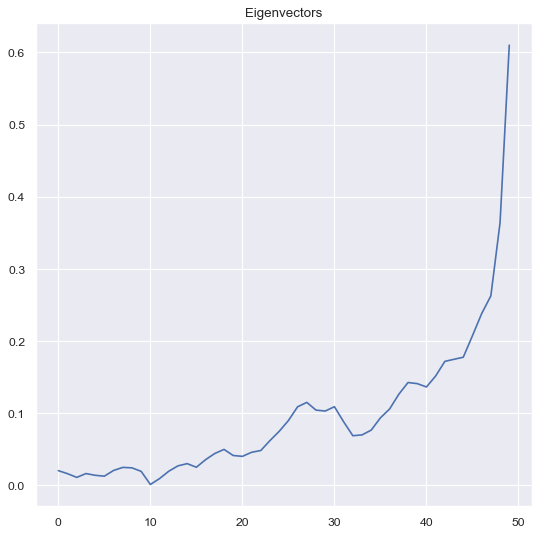

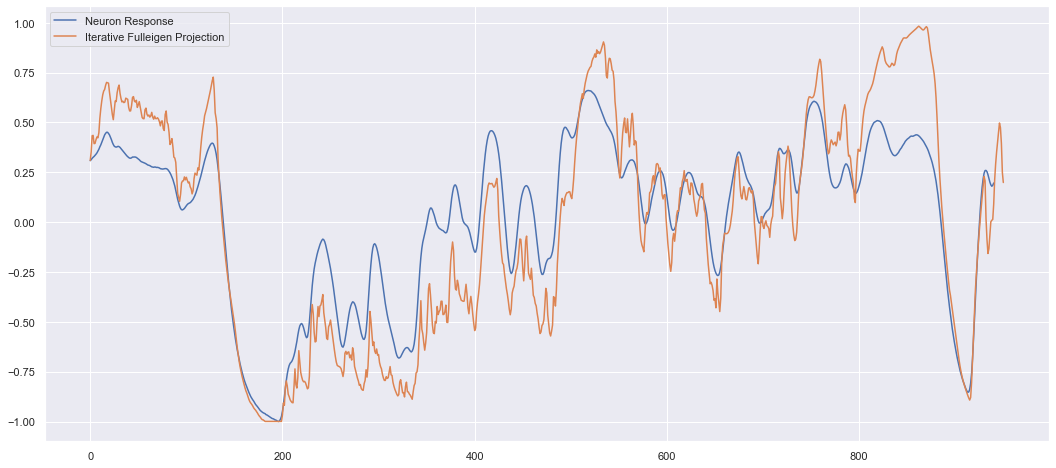

Correlation Shift: 59


In [4]:
# Iterative Time-Eigen Projection
down = 10
sig = normalize(np.mean(stimPH[:, ::down], axis=0))
res = normalize(np.mean(resPH[:, ::down], axis=0))

shift = 1
dim = 50
r_dim = 10
lamb = 100

X = build_hankel(sig, dim)
X0 = X[:, :-shift].T
Xp = X[:, shift:].T
print(X0.shape, Xp.shape)
# regularize 
X0 = np.concatenate([X0, np.sqrt(lamb)*np.eye(dim)])
Xp = np.concatenate([Xp, np.zeros((dim,dim))])

print(X0.shape, Xp.shape)

A, _, _, _ = scipy.linalg.lstsq(X0, Xp)

# A_red = low_rank_approx(A, r=r_dim)

evals, evecs = scipy.linalg.eig(A, left=False, right=True)

# get all real parts
evals = np.real(np.real_if_close(evals))
evecs = np.real(np.real_if_close(evecs))

# get largest eigenvector
largest_evec = evecs[:, np.nanargmax(evals)]

# multiple by sign of last component??
largest_evec *= np.sign(largest_evec[-1])

# project original series onto largest_evec
proj_series = largest_evec @ X


figure(figsize = (8, 8), dpi = 80)
plt.plot(largest_evec)
plt.title(f"Eigenvectors")
plt.show()

lags, corr = cross_corr(res, proj_series)
max_corr_index = lags[np.argmax(corr)]
sgn = np.sign(np.max(corr))

proj_series = normalize(proj_series)
plt.plot(res[max_corr_index:], label="Neuron Response")
plt.plot(proj_series, label="Iterative Fulleigen Projection")
plt.legend(); plt.show();

print("Correlation Shift:", max_corr_index)



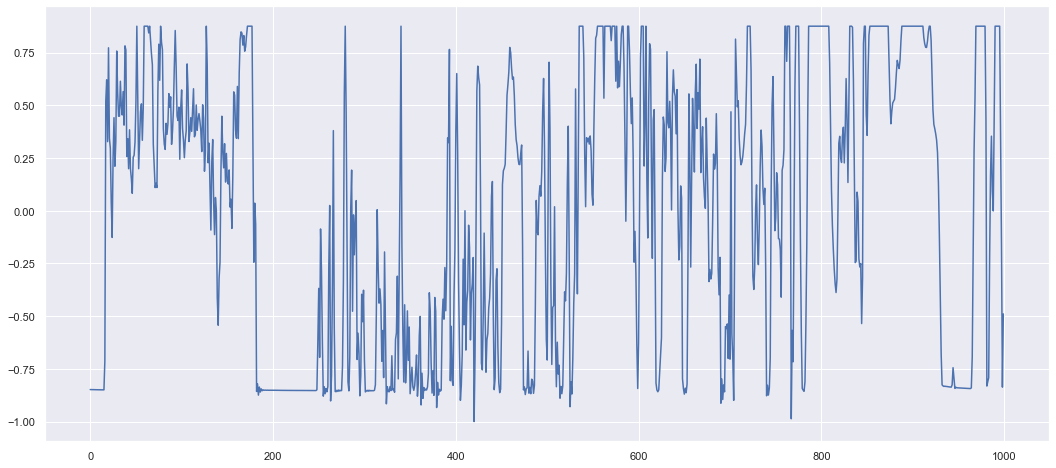

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


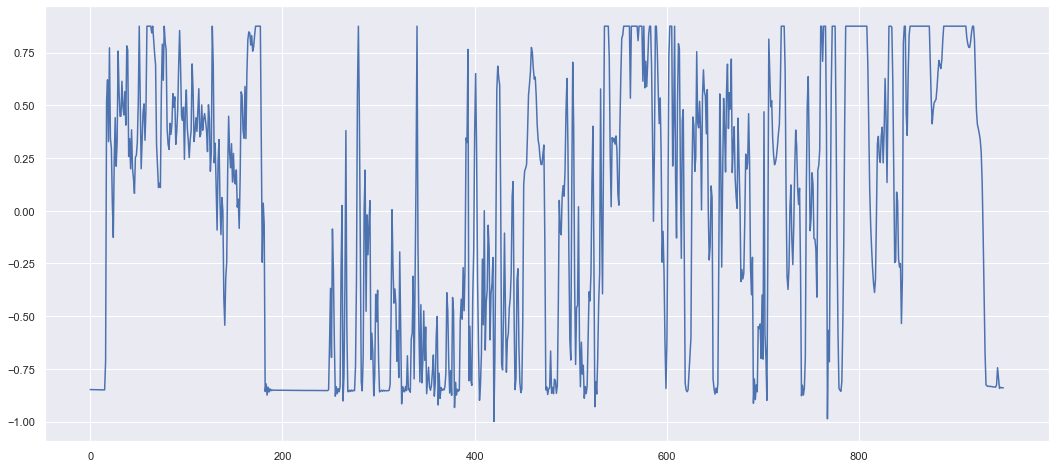

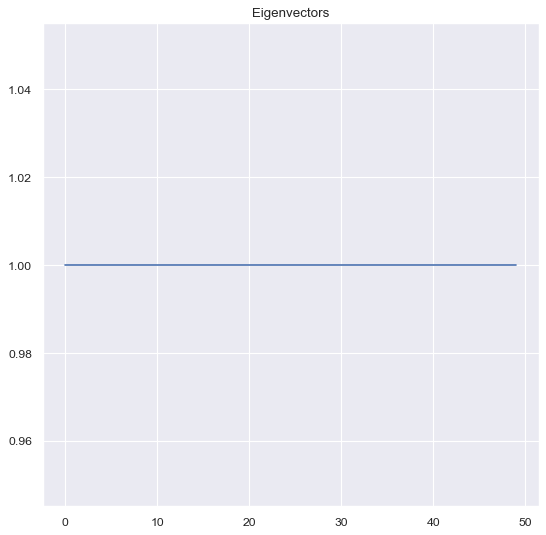

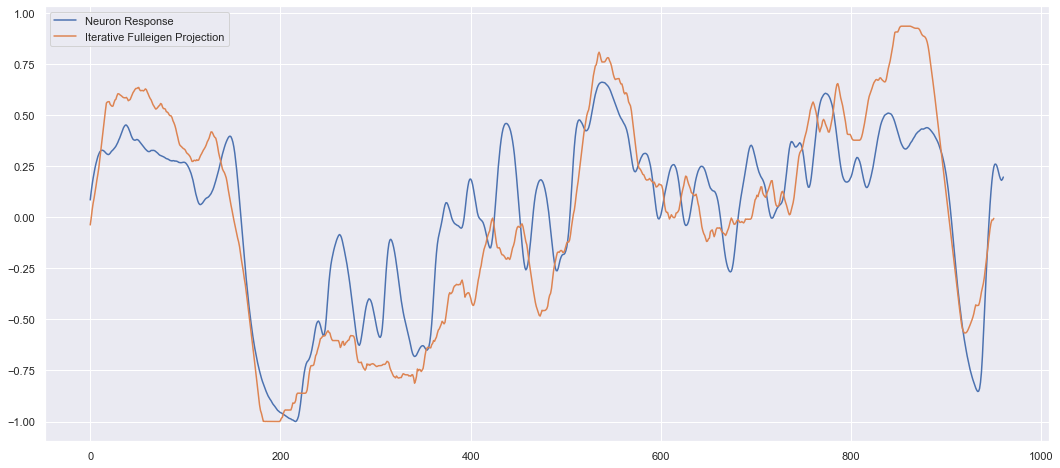

Correlation Shift: 39


In [20]:
# Iterative Time-Eigen Projection
down = 10
sig = normalize(np.mean(stimPH[:, ::down], axis=0))
res = normalize(np.mean(resPH[:, ::down], axis=0))

shift = 1
dim = 50
r_dim = 10
lamb = 0

plt.plot(sig); plt.show();

X = build_hankel(sig, dim)
X0 = X[:, :-shift].T
Xp = X[:, shift:].T

ex = np.linspace(0,4,dim)
rand_evec = np.ones(dim)

# project original series onto largest_evec
print(rand_evec)
plt.plot(X[0])
proj_series = rand_evec @ X


figure(figsize = (8, 8), dpi = 80)
plt.plot(rand_evec)
plt.title(f"Eigenvectors")
plt.show()

lags, corr = cross_corr(res, proj_series)
max_corr_index = lags[np.argmax(corr)]
sgn = np.sign(np.max(corr))

proj_series = normalize(proj_series*sgn)

if max_corr_index > 0:
    shift_res = res[max_corr_index:]
if max_corr_index < 0:
    shift_res = res[:-max_corr_index]

plt.plot(shift_res, label="Neuron Response")
plt.plot(proj_series, label="Iterative Fulleigen Projection")
plt.legend(); plt.show();

print("Correlation Shift:", max_corr_index)

